# Group Project



Formar grupos de 2, máximo 3 pessoas.

**Dataset:** https://www.kaggle.com/tmdb/tmdb-movie-metadata


**Objectivo:** Usar técnicas de regressão para prever a rating de um filme com base em diferentes características. 


**Notas importantes**
    
    1. Usar a coluna "vote_average" como target.
    2. Usar técnicas de regressão para prever a rating (vote_average) que um filme terá com base em diferentes caracteristicas.
    
**Recomendações**
    
    1. Não é necessário, nem recomendável, usar todas as features disponíveis (especialmente as que não são númericas).
    2. O exercício pode demorar muito ou pouco tempo, dependendo da exploração que for feita. Não é esperado que sejam explorados todos os detalhes, nem todas as abordagens possíveis.
    3. Se houver falta de tempo para explorar tudo o que gostariam, ou querem fazer alguma técnica que iria levar muito tempo, expliquem por escrito qual era a ideia e o que esperariam obter.
    4. Tentem explicar o máximo possível o racícionio por detrás de todos os passos que afectuarem.
    5. Acima de tudo, divirtam-se!
    
**Perguntas**

    1. Quantos filmes existem no dataset? E quantas features?
    2. Existem variáveis que não são independentes entre si?
    3. Qual a técnica de regressão que levou a melhores resultados?
    4. Quais os factores que mais contribuem para o sucesso de um filme?
    5. Recomendariam o vosso modelo a uma produtora de filmes?
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


seed = 42

In [2]:
df = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
# criar um dataset copia
movies = df.copy()

In [4]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [5]:
movies.shape

(4803, 20)

In [6]:
movies.id.nunique()

4803

#### 1. Quantos filmes existem no dataset? E quantas features?

```
  - Existem 4803 filmes no dataset. 
  - Existem 19 features no dataset
```



# Data cleaning 

In [18]:
#Identificação de variáveis potencialmente irrelevantes (muitas categorias + muitos missing values)
(movies.select_dtypes('O').isna().sum() + movies.select_dtypes('O').nunique())/movies.shape[0]

genres                  0.244639
homepage                0.995628
keywords                0.879034
original_language       0.007704
original_title          0.999584
overview                1.000000
production_companies    0.769727
production_countries    0.097647
release_date            0.683115
spoken_languages        0.113263
status                  0.000625
tagline                 0.996877
title                   0.999375
dtype: float64

Vamos começar por eliminar features que consideramos pouco interessantes no contexto deste projeto. São elas:


1.   id
2.   homepage 
3.   original_title 
4.   overview	
5.   tagline
6.   vote_count

Estas features ou são únicas ou missing para cada filme. Enquanto que do id não conseguimos tirar qualquer conhecimento, isto não significa, necessariamente, que não haja conhecimento presente nas restantes 4 variáveis - o título pode-nos remeter para algum tipo de franchise reconhecido pela crítica, a descrição e as taglines podem ter palavras chaves associadas ao sucesso do filme e a homepage, para além de nos dar acesso a conteúdo que, através de um _scrapper_, poderia ajudar a classificar o filme com mais detalhe, pode-nos dar mais dados sobre as produtoras e a relevância entre elas.

No entanto, por uma questão de custo-benefício, acreditamos que devemos centrar os esforços na restante informação que temos e que não será tão esparsa como a que poderíamos obter por estas variáveis.

É também difícil perceber a utilidade da vote_count, uma vez que só temos acesso a esta variável no mesmo momento em que a pontuação do filme é atribuída, dando origem a um data leak.




In [19]:
columns_todrop = ["id","homepage","original_title","overview","tagline", 'vote_count']

In [20]:
movies = movies.drop(columns=columns_todrop, axis=1)

In [21]:
movies.shape

(4803, 14)

O dataset possui alguma features que estão em formato json. Vamos simplificar estas colunas para ser mais fácil analisá-las.  

In [23]:
# ver a 1ª linha do genres
print(movies.genres.iloc[0] +"\n")
print(movies.keywords.iloc[0]+ "\n")
print(movies.production_companies.iloc[0]+ "\n")
print(movies.production_countries.iloc[0] + "\n")
print(movies.spoken_languages.iloc[0] + "\n")

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]

[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]

[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune 

In [25]:
for column in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
    max_length = max([len(eval(item)) for item in df[column]])
    print('A coluna {a} tem, potencialmente, {b} valores'.format(a=column , b=max_length))

A coluna genres tem, potencialmente, 7 valores
A coluna keywords tem, potencialmente, 97 valores
A coluna production_companies tem, potencialmente, 26 valores
A coluna production_countries tem, potencialmente, 12 valores
A coluna spoken_languages tem, potencialmente, 9 valores


Todas as features estão respresentadas em forma de dicionario ( key, value) em que o value é em todas o "name". Vamos criar uma função que nos extrai todos os name e nos coloca em forma de lista. 

In [27]:
from pandas.io.json import json_normalize
import json
def json_decode(data,key):
    
    """
Description: This function can be helpful to perform decoding in Python of JSON string.

Arguments:
    data: the data that we want decoding. 
    key: the key that we want to return its value.

Returns:
    list of values
"""
    result = []
    data = json.loads(data) #convert to json from string
    for item in data: #convert to list from json
        result.append(item[key])
    return result

In [28]:
for column in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
    movies[column] = movies[column].apply(json_decode,key='name')

In [0]:
movies.spoken_languages = movies.spoken_languages.apply(json_decode,key='name')

In [29]:
movies.head()

,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Avatar,7.2
1,300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,Pirates of the Caribbean: At World's End,6.9
2,245000000,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",en,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,Spectre,6.3
3,250000000,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",en,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Dark Knight Rises,7.6
4,260000000,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",en,43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],Released,John Carter,6.1


In [30]:
movies.dtypes

budget                    int64
genres                   object
keywords                 object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
title                    object
vote_average            float64
dtype: object

In [31]:
movies.dtypes.value_counts()

object     9
float64    3
int64      2
dtype: int64

O dataset possui variáveis categóricas(8) e numéricas(5), das quais uma é a target

In [32]:
#estatistca para variáveis numéricas
movies.describe()

,budget,popularity,revenue,runtime,vote_average
count,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000
75%,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000


Pelo describe verificamos algo estranho para as variáveis budget, revenue e runtime que possuem como valores minimos 0. O percentil de 25 para a variável revenue é 0! Isto parece não fazer muito sentido. 

In [33]:
#filtrar budget == 0 

movies_budget_zero = movies[movies['budget'] == 0]

movies_budget_zero.shape[0]/movies.shape[0]*100

21.590672496356444

21,6 % das observações têm valor 0 para a variável budget.

In [34]:
movies_budget_zero.head()

,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average
265,0,"[Comedy, Fantasy, Family]","[cat, brother sister relationship, boredom, ch...",en,18.251129,"[Imagine Entertainment, DreamWorks SKG, Univer...",[United States of America],2003-11-21,0,82.0,[English],Released,The Cat in the Hat,4.9
321,0,[Comedy],"[politics, politician, election campaign, nor...",en,16.460356,"[Everyman Pictures, Gary Sanchez Productions, ...",[United States of America],2012-08-09,104907746,85.0,[English],Released,The Campaign,5.6
359,0,"[Adventure, Animation, Comedy, Family]","[chipmunk, cgi, talking animal, aftercreditsst...",en,27.867368,"[Regency Enterprises, Fox 2000 Pictures, Sunsw...",[United States of America],2015-12-17,233755553,92.0,[English],Released,Alvin and the Chipmunks: The Road Chip,5.8
406,0,"[Drama, Animation, Family, Comedy]","[holiday, santa claus, duringcreditsstinger, w...",en,19.836830,"[Columbia Pictures, Aardman Animations, Sony P...",[United States of America],2011-02-22,0,97.0,[English],Released,Arthur Christmas,6.7
409,0,"[Drama, Music]","[show business, film making, tap dancing, movi...",en,5.159407,"[Twentieth Century Fox Film Corporation, Colum...",[United States of America],1979-12-20,37823676,123.0,[English],Released,All That Jazz,7.3


Através de pesquisas no google verificámos que, por exemplo, o filme "The Cat in the Hat" teve um budget de 109 milhões de dolares e o "All That Jazz" 12 millhões. Concluímos assim que os 0 para a feature budget foram erros de registo. 

Surge aqui um dilema na hora de manter ou eliminar estas observações. São muitas observações e eliminá-las pode levar a um modelo menos robusto. Por outro lado mantê-las vai enviezar os resultados. 
A opção mais correta seria tentar o seu preenchimento. Poderiamos ir consultar outras fontes de dados, ou fazer web scraping de forma a encontrar o budget para estes casos e depois completar estes registos. Por falta de tempo, e uma vez que o principal objetivo deste projeto é a aplicação do modelo final vamos optar por eliminar estas observações.

In [35]:
#filtrar revenue == 0 

movies_revenue_zero = movies[movies['revenue'] == 0]

In [36]:
movies_revenue_zero.shape[0]/movies.shape[0]*100

29.710597543202166

In [37]:
movies_revenue_zero.head()

,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average
83,27000000,"[Action, Adventure, Science Fiction, Romance]",[],en,2.418535,"[Corsan, Bliss Media, Limelight International ...","[Australia, Belgium, India]",2015-02-13,0,109.0,[English],Released,The Lovers,4.8
135,150000000,"[Drama, Horror, Thriller]","[father son relationship, victorian england, r...",en,21.214571,"[Universal Pictures, Stuber Productions, Relat...",[United States of America],2010-02-11,0,102.0,[English],Released,The Wolfman,5.5
265,0,"[Comedy, Fantasy, Family]","[cat, brother sister relationship, boredom, ch...",en,18.251129,"[Imagine Entertainment, DreamWorks SKG, Univer...",[United States of America],2003-11-21,0,82.0,[English],Released,The Cat in the Hat,4.9
309,84000000,"[Fantasy, Comedy, Family, Adventure]","[baby, mask, viking]",en,17.815595,"[New Line Cinema, Pathé Distribution]","[Germany, United States of America]",2005-02-18,0,94.0,[English],Released,Son of the Mask,3.6
376,90000000,"[Science Fiction, Action, Drama, Thriller]","[subway, lava, volcano, volcanologist, los ang...",en,19.836124,[Twentieth Century Fox Film Corporation],[United States of America],1997-04-25,0,104.0,"[Deutsch, Español, English]",Released,Volcano,5.2


Vamos seguir o mesmo critério que seguimos para o "budget"

In [38]:
#filtrar runtime == 0 

movies_runtime_zero = movies[movies['runtime'] == 0]

In [39]:
movies_runtime_zero.shape[0]/movies.shape[0]*100

0.7287112221528211

aqui já são apenas 0,73% das observações. Vamos proceder primeiro à eliminação das observações que se encontram a 0 para o budget e para o Revenue e depois caso se mantenham estes casos vamos analisar outra vez. 

In [40]:
# drop budget == 0 
movies = movies[movies.budget != 0]

In [41]:
movies[movies['budget'] == 0].shape

(0, 14)

In [42]:
# drop revenue == 0 
movies = movies[movies.revenue != 0]

In [43]:
movies[movies['revenue'] == 0].shape

(0, 14)

In [44]:
movies.shape

(3229, 14)

Temos agora um dataser com 3229 observações. 
Vamos ver se ainda existem observações com runtime == 0 

In [45]:
movies.runtime.min()

41.0

Já não existem !

Vamos agora ver se existem missing values. 

In [46]:
movies.isnull().sum()

budget                  0
genres                  0
keywords                0
original_language       0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
vote_average            0
dtype: int64

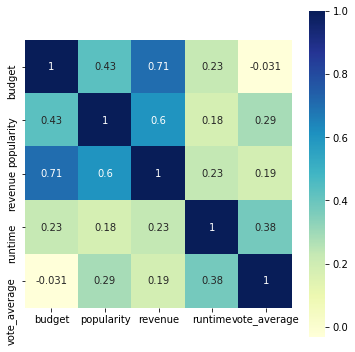

In [47]:
#correlação variáveis numéricas
#

fig = plt.figure(figsize = (6,6),facecolor="white")

sns.heatmap(movies.corr(), annot = True, cmap = 'YlGnBu', square= True)

plt.show()

#### Existem variáveis que não são independentes entre si??

```
Pelo heatmap verificamos que existem alguma correlações consideráveis, principalmente nos casos: 

1.   revenue vs budget
2.   revenue vs popularity

Por outro lado as variáveis vote_average e budget têm uma correlação quase insignificante e por isso pode dizer-se que são independentes. 




```


## Variáveis Categóricas

In [57]:
movies.dtypes

budget                    int64
genres                   object
keywords                 object
original_language        object
popularity              float64
production_companies     object
production_countries     object
revenue                   int64
runtime                 float64
spoken_languages         object
title                    object
vote_average            float64
year                      int64
month                     int64
dtype: object

In [58]:
movies.select_dtypes(exclude=['int64','float64']).head(2)

,genres,keywords,original_language,production_companies,production_countries,spoken_languages,title
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]",Avatar
1,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English],Pirates of the Caribbean: At World's End


In [60]:
movies.original_language.value_counts(normalize=True).head()

en    0.960657
fr    0.007745
es    0.004647
ja    0.004027
zh    0.004027
Name: original_language, dtype: float64

96% das observações pertence à classe en. uma vez que a variância desta feature é quase 0 vamos eliminá-la.

In [61]:
movies = movies.drop(columns = ['original_language'] , axis= 1)

In [53]:
movies.status.value_counts()

Released    3228
Name: status, dtype: int64

Seguindo o mesmo raciocínio, vamos eliminar a variável status

In [54]:
 movies = movies.drop(columns=['status'] , axis = 1 )

A release_date trata-se de uma data. O dia, intuitivamente, parece-nos irrelevante considerar. Contudo, o ano e o mês podem trazer informação relevante: bons filmes são tipicamente lançados perto de datas de festivais. O ano também pode ter algum efeito sazonal.

In [48]:
movies.release_date = pd.to_datetime(movies['release_date'])
movies["year"] = movies.release_date.dt.year
movies['month'] = movies.release_date.dt.month

In [49]:
movies = movies.drop(columns=['release_date'], axis = 1)

In [63]:
movies.head(5)

,budget,genres,keywords,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,title,vote_average,year,month
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2787965087,162.0,"[English, Español]",Avatar,7.2,2009,12
1,300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],961000000,169.0,[English],Pirates of the Caribbean: At World's End,6.9,2007,5
2,245000000,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Spectre,6.3,2015,10
3,250000000,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],1084939099,165.0,[English],The Dark Knight Rises,7.6,2012,7
4,260000000,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",43.926995,[Walt Disney Pictures],[United States of America],284139100,132.0,[English],John Carter,6.1,2012,3


In [64]:
movies.select_dtypes(exclude=['int64','float64']).head(2)

,genres,keywords,production_companies,production_countries,spoken_languages,title
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]",Avatar
1,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English],Pirates of the Caribbean: At World's End


In [65]:
movies.shape

(3228, 13)

Vamos agora olhar para as variáveis que estão apresentadas como lista. 

--Genres

In [66]:
genres = set()
for item in movies.genres:
    for genre in item:
        genres.add(genre)
genres = list(genres)
print(genres)

['Action', 'Fantasy', 'History', 'Comedy', 'War', 'Foreign', 'Western', 'Animation', 'Documentary', 'Drama', 'Science Fiction', 'Mystery', 'Music', 'Adventure', 'Thriller', 'Family', 'Horror', 'Romance', 'Crime']


In [67]:
len(genres)

19

Vamos agora transformar os valores ditintos em colunas para posteriormente fazer join com o dataframe movies. 


In [68]:
df_genres = pd.DataFrame(columns=genres)
df_genres.head()

,Action,Fantasy,History,Comedy,War,Foreign,Western,Animation,Documentary,Drama,Science Fiction,Mystery,Music,Adventure,Thriller,Family,Horror,Romance,Crime


In [69]:
for index, row in movies.iterrows():
    for item in row['genres']:
        df_genres.loc[index,item] = 1
df_genres.head(3)

,Action,Fantasy,History,Comedy,War,Foreign,Western,Animation,Documentary,Drama,Science Fiction,Mystery,Music,Adventure,Thriller,Family,Horror,Romance,Crime
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1


In [70]:
df_genres.shape

(3227, 19)

In [71]:
df_genres.fillna(0,inplace=True)

In [72]:
# ver a distribuição por generos
for column in df_genres:
  print("{}: {}".format(column,df_genres[column][df_genres[column]==1].shape[0]))

Action: 918
Fantasy: 342
History: 145
Comedy: 1110
War: 120
Foreign: 5
Western: 57
Animation: 188
Documentary: 38
Drama: 1440
Science Fiction: 431
Mystery: 265
Music: 111
Adventure: 661
Thriller: 934
Family: 365
Horror: 332
Romance: 574
Crime: 521


In [73]:
movies = movies.join(df_genres)

In [74]:
movies.shape

(3228, 32)

In [75]:
movies.isnull().sum()

budget                  0
genres                  0
keywords                0
popularity              0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
spoken_languages        0
title                   0
vote_average            0
year                    0
month                   0
Action                  1
Fantasy                 1
History                 1
Comedy                  1
War                     1
Foreign                 1
Western                 1
Animation               1
Documentary             1
Drama                   1
Science Fiction         1
Mystery                 1
Music                   1
Adventure               1
Thriller                1
Family                  1
Horror                  1
Romance                 1
Crime                   1
dtype: int64

In [76]:
movies[movies.Music.isnull()]

,budget,genres,keywords,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,title,...,Drama,Science Fiction,Mystery,Music,Adventure,Thriller,Family,Horror,Romance,Crime
4105,2000000,[],[],0.031947,[],[],1672730,120.0,[],"The Book of Mormon Movie, Volume 1: The Journey",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Exite uma observação que não possui qualquer valor para o genero. vamos eliminá-lo. 

In [77]:
movies = movies[movies.title != 'The Book of Mormon Movie, Volume 1: The Journey']

In [78]:
movies.isnull().sum()

budget                  0
genres                  0
keywords                0
popularity              0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
spoken_languages        0
title                   0
vote_average            0
year                    0
month                   0
Action                  0
Fantasy                 0
History                 0
Comedy                  0
War                     0
Foreign                 0
Western                 0
Animation               0
Documentary             0
Drama                   0
Science Fiction         0
Mystery                 0
Music                   0
Adventure               0
Thriller                0
Family                  0
Horror                  0
Romance                 0
Crime                   0
dtype: int64

In [79]:
# eliminar coluna genres 
movies = movies.drop(columns=['genres'] , axis = 1 )

--Keywords


In [80]:
keywords = set()
for item in movies.keywords:
    for keyword in item:
        keywords.add(keyword)
keywords = list(keywords)
print(keywords)

['montmartre', 'history', 'anthology', 'cadillac convertible', 'orléans', 'oxygen', 'old house', 'saigon', 'grocery', "girls' boarding school", 'insecurity', 'middle east', 'loner', 'sports marketing firm', 'matter of life and death', 'benzine', 'motor neuron disease', 'bare knuckle fighting', 'commitment', 'desert scientist', 'dismemberment', 'weather', 'destruction', 'winzer', 'babysitter', 'leukemia', 'simulator', 'speaker phone', 'cab driver', 'battle for survival', 'formula 1', "hundred years' war", 'bus trip', 'defeat', 'monkey king', 'home front', 'fat suit', 'garden gnome', 'green beret', 'crocodile', 'diva', 'cultural difference', 'absorbing power', 'apache', 'peasant', 'reverend', 'reference to facebook', 'newfoundland', 'kaffeehaus', 'rich vs poor', 'admissions', 'auction', 'photo lab', 'battleship', 'leather jacket', 'forced prostitution', 'sin', 'dangerous', 'war of independence', 'starships', 'subway', 'red sea', 'inventions and discoveries', 'cover-up', 'british overseas

In [81]:
len(keywords)

8657

Existem mais keywords distintas do que filmes  o que indica que cada filme vai ter o seu conjunto de keywords  e estes varia muito de filme para filme.  Vamos eliminar esta variável. 

Nota: Caso existisse tempo poderíamos ir ver se existem keywords que aparecem com mais frequencia para vote_average superiores/ inferiores e assim criar clusters de keywords. 

In [0]:
# eliminar coluna keywords
movies = movies.drop(columns=['keywords'] , axis = 1 )

In [0]:
movies.head()

,budget,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,title,vote_average,vote_count,year,Western,Family,Music,Horror,Thriller,Science Fiction,Animation,Fantasy,Crime,War,Adventure,Documentary,Foreign,Drama,Mystery,Romance,Comedy,History,Action
0,237000000,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2787965087,162.0,"[English, Español]",Avatar,7.2,11800,2009,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,300000000,139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],961000000,169.0,[English],Pirates of the Caribbean: At World's End,6.9,4500,2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,245000000,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Spectre,6.3,4466,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,250000000,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],1084939099,165.0,[English],The Dark Knight Rises,7.6,9106,2012,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,260000000,43.926995,[Walt Disney Pictures],[United States of America],284139100,132.0,[English],John Carter,6.1,2124,2012,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


--production_companies

In [0]:
production_companies = set()
for item in movies.production_companies:
    for company in item:
        production_companies.add(company)
production_companies = list(production_companies)
print(production_companies)

['Heineken Branded Entertainment', 'Gospel of John Ltd.', 'Ten Thirteen Productions', 'On Entertainment', 'John Wells Productions', 'Tall Trees Productions', 'UIP', 'Marubeni', 'Kasdan Pictures', 'Outlaw Sinema', 'Liberty Pictures', 'Obelisk Productions', 'Versátil Cinema', 'Robert Simonds Productions', 'Endgame Entertainment', 'Pure Flix Entertainment', 'Sierra / Affinity', 'Baltimore Pictures', 'Zaftig Films', 'Mace Neufeld Productions', 'Canal Plus Group', 'Bonnie Timmermann Productions', 'Wadleigh-Maurice', 'Global Medien KG', 'Open Road Films', 'Such Much Films', 'Midnight Picture Show', 'Avenue Pictures Productions', 'Columbia Pictures Corporation', 'Miho Film', 'Occupant Entertainment', 'BrownHouse Productions', 'Alvernia Studios', 'Stéphan Films', 'Allied Stars, Ltd.', 'Sudden Storm Productions', '3D Entertainment', 'Dark Harbor Stories', 'Gaylord Films', 'Mitsubishi', 'TaliaFilm II Productions', 'Courtside Seats Productions', 'Constantin Film Ltd.', 'Blossom Films', 'Media Mag

In [0]:
len(production_companies)

3564

Visto o número grande de companhias de produção distintas vamos aplicar o mesmo racionio que foi aplicado para a feature keywords e vamos elimar esta feature 

In [0]:
movies = movies.drop(columns=['production_companies'] , axis = 1 )

--production_countries

In [0]:
production_countries = set()
for item in movies.production_countries:
    for country in item:
        production_countries.add(country)
production_countries = list(production_countries)
print(production_countries)

['Czech Republic', 'Romania', 'Finland', 'Norway', 'Italy', 'Hong Kong', 'Hungary', 'Singapore', 'Luxembourg', 'New Zealand', 'Bulgaria', 'Chile', 'France', 'Poland', 'Denmark', 'Austria', 'Thailand', 'Fiji', 'Iran', 'Spain', 'Bahamas', 'China', 'Morocco', 'Kazakhstan', 'Slovenia', 'Netherlands', 'Brazil', 'Portugal', 'Argentina', 'United Kingdom', 'Jamaica', 'Belgium', 'Greece', 'Indonesia', 'South Korea', 'Russia', 'Iceland', 'Lithuania', 'Switzerland', 'Dominica', 'South Africa', 'Japan', 'Australia', 'Serbia', 'Israel', 'Germany', 'Peru', 'United Arab Emirates', 'Sweden', 'Mexico', 'United States of America', 'Pakistan', 'Canada', 'Tunisia', 'Malta', 'India', 'Angola', 'Philippines', 'Serbia and Montenegro', 'Taiwan', 'Ireland']


In [0]:
len(production_countries)

61

In [0]:
df_production_countries = pd.DataFrame(columns=production_countries)
df_production_countries.head()

,Czech Republic,Romania,Finland,Norway,Italy,Hong Kong,Hungary,Singapore,Luxembourg,New Zealand,Bulgaria,Chile,France,Poland,Denmark,Austria,Thailand,Fiji,Iran,Spain,Bahamas,China,Morocco,Kazakhstan,Slovenia,Netherlands,Brazil,Portugal,Argentina,United Kingdom,Jamaica,Belgium,Greece,Indonesia,South Korea,Russia,Iceland,Lithuania,Switzerland,Dominica,South Africa,Japan,Australia,Serbia,Israel,Germany,Peru,United Arab Emirates,Sweden,Mexico,United States of America,Pakistan,Canada,Tunisia,Malta,India,Angola,Philippines,Serbia and Montenegro,Taiwan,Ireland


In [0]:
for index, row in movies.iterrows():
    for item in row['production_countries']:
        df_production_countries.loc[index,item] = 1
df_production_countries.head(3)

,Czech Republic,Romania,Finland,Norway,Italy,Hong Kong,Hungary,Singapore,Luxembourg,New Zealand,Bulgaria,Chile,France,Poland,Denmark,Austria,Thailand,Fiji,Iran,Spain,Bahamas,China,Morocco,Kazakhstan,Slovenia,Netherlands,Brazil,Portugal,Argentina,United Kingdom,Jamaica,Belgium,Greece,Indonesia,South Korea,Russia,Iceland,Lithuania,Switzerland,Dominica,South Africa,Japan,Australia,Serbia,Israel,Germany,Peru,United Arab Emirates,Sweden,Mexico,United States of America,Pakistan,Canada,Tunisia,Malta,India,Angola,Philippines,Serbia and Montenegro,Taiwan,Ireland
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_production_countries.fillna(0,inplace=True)

In [0]:
# ver a distribuição por pais 
for column in df_production_countries:
  print("{}: {}".format(column,df_production_countries[column][df_production_countries[column]==1].shape[0]))

Czech Republic: 16
Romania: 7
Finland: 3
Norway: 8
Italy: 48
Hong Kong: 26
Hungary: 8
Singapore: 1
Luxembourg: 6
New Zealand: 21
Bulgaria: 3
Chile: 2
France: 196
Poland: 4
Denmark: 9
Austria: 5
Thailand: 3
Fiji: 1
Iran: 1
Spain: 43
Bahamas: 3
China: 37
Morocco: 3
Kazakhstan: 1
Slovenia: 1
Netherlands: 14
Brazil: 5
Portugal: 1
Argentina: 3
United Kingdom: 436
Jamaica: 2
Belgium: 14
Greece: 2
Indonesia: 1
South Korea: 7
Russia: 11
Iceland: 5
Lithuania: 1
Switzerland: 12
Dominica: 1
South Africa: 9
Japan: 40
Australia: 78
Serbia: 1
Israel: 1
Germany: 233
Peru: 2
United Arab Emirates: 13
Sweden: 8
Mexico: 16
United States of America: 2907
Pakistan: 2
Canada: 162
Tunisia: 1
Malta: 4
India: 29
Angola: 1
Philippines: 1
Serbia and Montenegro: 1
Taiwan: 4
Ireland: 25


In [0]:
(df_production_countries[df_production_countries['United States of America'] ==1].shape[0]/movies.shape[0])*100

90.08366904245429

Verificamos que 90% das observações foram efetuadas em USA e por isso assumimos que não existes variância significatica e vamos elimar ets coluna também. 

In [0]:
movies = movies.drop(columns=['production_countries'] , axis = 1 )

--spoken_languages 

In [0]:
spoken_languages  = set()
for item in movies.spoken_languages :
    for spoken_language in item:
        spoken_languages.add(spoken_language)
spoken_languages  = list(spoken_languages )
print(spoken_languages)

['', 'हिन्दी', 'العربية', 'Gaeilge', 'ภาษาไทย', 'தமிழ்', 'shqip', 'isiZulu', 'қазақ', 'Somali', 'Slovenčina', 'Français', 'Eesti', 'Galego', '한국어/조선말', 'Português', 'English', 'Norsk', 'Polski', 'తెలుగు', 'ქართული', 'فارسی', '日本語', 'Hrvatski', 'Latin', 'Tiếng Việt', 'עִבְרִית', 'Español', 'Italiano', 'Română', 'Nederlands', 'Íslenska', 'Esperanto', 'ਪੰਜਾਬੀ', 'ελληνικά', 'Český', 'Magyar', 'বাংলা', 'Català', '广州话 / 廣州話', 'Dansk', 'Cymraeg', 'پښتو', 'Bahasa indonesia', '普通话', 'Afrikaans', 'suomi', 'Kiswahili', 'اردو', 'Srpski', 'Türkçe', 'Український', 'Deutsch', 'български език', 'No Language', 'Pусский', 'svenska', 'Bosanski']


In [0]:
len(spoken_languages)

58

In [0]:
df_spoken_languages= pd.DataFrame(columns=spoken_languages)
df_spoken_languages.head()

,,हिन्दी,العربية,Gaeilge,ภาษาไทย,தமிழ்,shqip,isiZulu,қазақ,Somali,Slovenčina,Français,Eesti,Galego,한국어/조선말,Português,English,Norsk,Polski,తెలుగు,ქართული,فارسی,日本語,Hrvatski,Latin,Tiếng Việt,עִבְרִית,Español,Italiano,Română,Nederlands,Íslenska,Esperanto,ਪੰਜਾਬੀ,ελληνικά,Český,Magyar,বাংলা,Català,广州话 / 廣州話,Dansk,Cymraeg,پښتو,Bahasa indonesia,普通话,Afrikaans,suomi,Kiswahili,اردو,Srpski,Türkçe,Український,Deutsch,български език,No Language,Pусский,svenska,Bosanski


In [0]:
for index, row in movies.iterrows():
    for item in row['spoken_languages']:
        df_spoken_languages.loc[index,item] = 1
df_spoken_languages.head(3)

,,हिन्दी,العربية,Gaeilge,ภาษาไทย,தமிழ்,shqip,isiZulu,қазақ,Somali,Slovenčina,Français,Eesti,Galego,한국어/조선말,Português,English,Norsk,Polski,తెలుగు,ქართული,فارسی,日本語,Hrvatski,Latin,Tiếng Việt,עִבְרִית,Español,Italiano,Română,Nederlands,Íslenska,Esperanto,ਪੰਜਾਬੀ,ελληνικά,Český,Magyar,বাংলা,Català,广州话 / 廣州話,Dansk,Cymraeg,پښتو,Bahasa indonesia,普通话,Afrikaans,suomi,Kiswahili,اردو,Srpski,Türkçe,Український,Deutsch,български език,No Language,Pусский,svenska,Bosanski
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN


In [0]:
df_spoken_languages.fillna(0,inplace=True)

In [0]:
# ver a distribuição por lingua
for column in df_spoken_languages:
  print("{}: {}".format(column,df_spoken_languages[column][df_spoken_languages[column]==1].shape[0]))

: 36
हिन्दी: 23
العربية: 55
Gaeilge: 4
ภาษาไทย: 34
தமிழ்: 2
shqip: 3
isiZulu: 2
қазақ: 1
Somali: 2
Slovenčina: 1
Français: 304
Eesti: 2
Galego: 1
한국어/조선말: 23
Português: 46
English: 3134
Norsk: 7
Polski: 29
తెలుగు: 1
ქართული: 1
فارسی: 7
日本語: 82
Hrvatski: 3
Latin: 43
Tiếng Việt: 15
עִבְרִית: 25
Español: 273
Italiano: 143
Română: 9
Nederlands: 7
Íslenska: 5
Esperanto: 2
ਪੰਜਾਬੀ: 1
ελληνικά: 19
Český: 29
Magyar: 24
বাংলা: 1
Català: 1
广州话 / 廣州話: 32
Dansk: 7
Cymraeg: 2
پښتو: 1
Bahasa indonesia: 2
普通话: 79
Afrikaans: 5
suomi: 3
Kiswahili: 5
اردو: 13
Srpski: 4
Türkçe: 15
Український: 9
Deutsch: 179
български език: 3
No Language: 2
Pусский: 148
svenska: 16
Bosanski: 1


In [0]:
(df_spoken_languages[df_spoken_languages['English'] ==1].shape[0]/movies.shape[0])*100

97.11806631546328

97% dos filmes possuem o inglês como idioma.Uma vez que é uma carateristica quase presente em todas as observações vamos eliminar esta feature também. 

In [0]:
movies = movies.drop(columns=['spoken_languages'] , axis = 1 )

Vamos eliminar a coluna title também visto que já não necessitamos mais dela e é uma feature identificativa. 

In [0]:
movies = movies.drop(columns=['title'] , axis = 1 )

In [0]:
movies.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,year,Western,Family,Music,Horror,Thriller,Science Fiction,Animation,Fantasy,Crime,War,Adventure,Documentary,Foreign,Drama,Mystery,Romance,Comedy,History,Action
0,237000000,150.437577,2787965087,162.0,7.2,11800,2009,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,300000000,139.082615,961000000,169.0,6.9,4500,2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,245000000,107.376788,880674609,148.0,6.3,4466,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,250000000,112.312950,1084939099,165.0,7.6,9106,2012,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,260000000,43.926995,284139100,132.0,6.1,2124,2012,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [0]:
movies.select_dtypes(exclude=['int64','float64']).head(2)

""
0
1


Já todas as nosssa features estão em formato numérico.  


## Modelo

Vamos então dividir o dataset em treino e teste:

In [0]:
train_set, test_set = train_test_split(movies, test_size = 0.2, random_state = seed)

In [0]:
X_train = train_set.drop(['vote_average'], axis = 1)
y_train = train_set['vote_average']

X_test = test_set.drop(['vote_average'], axis = 1)
y_test = test_set['vote_average']

In [0]:
X_test.isnull().sum()

budget             0
popularity         0
revenue            0
runtime            0
vote_count         0
year               0
Western            0
Family             0
Music              0
Horror             0
Thriller           0
Science Fiction    0
Animation          0
Fantasy            0
Crime              0
War                0
Adventure          0
Documentary        0
Foreign            0
Drama              0
Mystery            0
Romance            0
Comedy             0
History            0
Action             0
dtype: int64

Normalização:

In [0]:
scaler = MinMaxScaler()

features_names = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = features_names)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = features_names)

--Regression linear

In [0]:
lr = LinearRegression().fit(X_train, y_train)

In [0]:
y_preds = lr.predict(X_test)

In [0]:
lr.score(X_test, y_test)

0.4046517693714917

In [0]:
r2_score(y_test, y_preds)

0.4046517693714917

-- Non Linear Multiple Regression

In [0]:
nonlinear_model = Pipeline( steps = [('poly', PolynomialFeatures(degree = 3)),
                                 ('linear', LinearRegression())])

In [0]:
multiple_poly_model = nonlinear_model.fit(X_train, y_train)

In [0]:
preds_multiple_poly = nonlinear_model.predict(X_test)

In [0]:
r2_multiple_poly = r2_score(y_test, preds_multiple_poly)

In [0]:
r2_multiple_poly

-1.1285608080348057e+20